### TODO list for this code:
1. Check how high fps I can have in the manim animation without the program crashing. fps=10 works
2. Check if I should use max(Umaxmax,Vmaxmax) for the colors in the manim animation.
3. Figure out how to manage the UV and VV so they don't get too big when I use more time steps.
4. Ask Amanda to check the code and the commenting out.
5. Try to change the parameters for all the different reaction models.


### Importing numpy, odeint, and matplotlib

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from manim import *
config.max_files_cached = 200

Manim Community v0.16.0.post0

In [3]:
def laplacian(U):
    [r,c] = np.shape(U) #[r,c] is the number of rows and columns in the matrix/array U.
    
    ordning_UH = np.linspace(1,c-1,c-1, dtype=np.int32) #if for example c=5 -> ordning_UH = [1,2,3,4]
    ordning_UH = np.append(ordning_UH,0) # Adds a 0 at the end. If for example c=5 -> ordning_UH = [1,2,3,4,0]
    
    ordning_UV = np.linspace(0,c-2,c-1, dtype=np.int32) #if for example c=5 -> ordning_UV = [0,1,2,3]
    ordning_UV = np.concatenate([[c-1],ordning_UV]) #Adds a c-1 to the start. If for example c=5 -> ordning_UH = [4,0,1,2,3]
    
    if (r==c):
        ordning_UN = ordning_UH
        ordning_UU = ordning_UV
    else:
        ordning_UN = np.linspace(1,r-1,r-1, dtype=np.int32) #if for example r=5 -> ordning_UH = [1,2,3,4]
        ordning_UN = np.append(ordning_UN,0)# Adds a 0 at the end. If for example r=5 -> ordning_UH = [1,2,3,4,0]
        
        ordning_UU = np.linspace(0,r-2,r-1, dtype=np.int32) #if for example r=5 -> ordning_UV = [0,1,2,3]
        ordning_UU = np.concatenate([[r-1],ordning_UU]) #Adds a r-1 to the start. If for example r=5 -> ordning_UH = [4,0,1,2,3]
    
    """
    If U = [1,2,3] Then UH = [2,3,1], UV = [3,1,2], UN = [4,5,6], UU = [7,8,9]
           [4,5,6]           [5,6,4]       [6,4,5]       [7,8,9]       [1,2,3]
           [7,8,9]           [8,9,7]       [9,7,8]       [1,2,3]       [4,5,6]
    """
    
    UH = U[:,ordning_UH]
    UV = U[:,ordning_UV]    
    UN = U[ordning_UN,:]
    UU = U[ordning_UU,:]
    #print(UU)
    
    laplacianU = UH + UV + UN + UU -4*U
    return laplacianU

## Reaction models

### The Schnakenberg model of reaction

$$
\left. \begin{aligned}
& f(U,V) = c_1 - c_{-1}U + c_3 U^2 V \\
& g(U,V) = c_4 U^2 - c_5 V
\end{aligned} \right\}
$$

In [4]:
def  Schnakenberg(U,V):
    c1 = 0.1
    c2 = 0.9
    cm1 = 1
    c3 = 1
    DU = 1
    DV = 40
    
    f = c1 - cm1*U + c3*U*U*V
    g = c2 - c3*U*U*V
    
    laplacianU = laplacian(U)
    laplacianV = laplacian(V)
    
    deltaU = DU*laplacianU + f
    deltaV = DV*laplacianV + g
    
    #f_u = -cm1 + c3*2*U*V
    #g_v = -c3*U*U
    
    #fugv = f_u+g_v
    #if (fugv.max()>0):
    #    print("maxvärdet av f_u + g_v: ", fugv.max())
    
    
    return [deltaU,deltaV]

### The  Gierer –Meinhardt model of reaction

$$
\left. \begin{aligned}
& f(U,V) = c_1 - c_2 U + c_3 \frac{U^2}{(1+kU^2)V} \\
& g(U,V) = c_4 U^2 - c_5 V
\end{aligned} \right\}
$$

In [5]:
def GiererMeinhardt(U,V):
    c1 = 1
    c2 = 1
    c3 = 1
    c4 = 1
    c5 = 1
    k  = 1
    DU = 1
    DV = 1
    
    f = c1 - c2*U + c3*(U*U/((1+k*U*U)*V))
    g = c4*U*U - c5*V
    
    laplacianU = laplacian(U)
    laplacianV = laplacian(V)
    
    deltaU = DU*laplacianU + f
    deltaV = DV*laplacianV + g
    
    #Beräknar detta för att kunna använda derivatans kvotregel. 
    #ft = U*U #Täljar-delen av f
    #ft_u = 2*U #Derivatan av täljar-delen av f
    #fn = (1+k*U*U)*V #Nämnar-delen av f
    #fn_u = 2*k*U #Derivatan av nämnar-delen av f
    
    #f_u = -c2 + c3*(ft_u*fn-ft*fn_u/(fn*fn)) #Derivatan av f med avseende på U. 
    
    #g_v = c5
    
    #fugv = f_u+g_v
    #if (fugv.max()>0):
    #    print("maxvärdet av f_u + g_v: ", fugv.max())
    
    return [deltaU,deltaV]

#### The reaction model angelfishPomacanthus(U,V) is taken from the article: A reaction–diffusion wave on the skin of the marine angelfish Pomacanthus. https://www.nature.com/articles/376765a0

$$
\left. \begin{aligned}
& f(U,V) = c_1 U + c_2 V + c_3 -g_A U \\
& g(U,V) = c_4 U + c_5 - g_V V 
\end{aligned} \right\}
$$

In [6]:
def angelfishPomacanthus(U,V):
    c1 = 0.08
    c2 = -0.08
    c3 = 0.05
    ga = 0.03
    c4 = 0.1
    c5 = -0.15
    gl = 0.06
    DU = 0.007
    DV = 0.03
    
    f = c1*U + c2*V + c3 - ga*U
    g = c4*U + c5 - gl*V
    
    laplacianU = laplacian(U)
    laplacianV = laplacian(V)
    
    deltaU = DU*laplacianU + f
    deltaV = DV*laplacianV + g
    
    return [deltaU,deltaV]
    

### Gray-Scott model:
https://mrob.com/pub/comp/xmorphia/

$$ \begin{split} & \frac{\partial u}{\partial t} = D_u \nabla^2 u - uv^2 + F(1-u),\\
& \frac{\partial v}{\partial t} = D_v \nabla^2 v + uv^2  (F+k)v
\end{split} $$


In [7]:
def GrayScott(U,V):
    F = 0.062
    k = 0.063
    DU = 0.06
    DV = 0.12
    
    f = -U*V*V + F*(1-U)
    g = U*V*V - (F+k)*V
    
    laplacianU = laplacian(U)
    laplacianV = laplacian(V)
    
    deltaU = DU*laplacianU + f
    deltaV = DV*laplacianV + g
    
    return [deltaU,deltaV]

### Alan Turings model (equation 6.2 in the article) 

$$ \left. \begin{split} & \frac{dx}{dt} = ax_r + by_r + \mu (x_{r+1} - 2x_r + x_{r-1}), \\
 & \frac{dy}{dt} = cy_r + dy_r + \nu (y_{r+1} - 2y_r + y_{r-1})
\end{split} \right\}
$$

In [8]:
def AlanTuring(U,V):
    #a = 1; b = 1; c = b; d = a; DU = 1/4; DV = 1/4 #Makes no pattern and the concentration of U increases exponentially
    a = 1; b = 1; c = -b; d = a; DU = 1/4; DV = 1/4  #Same as above
    
    f = a*U + b*V
    g = c*U + d*V
    
    laplacianU = laplacian(U)
    laplacianV = laplacian(V)
    
    deltaU = DU*laplacianU + f
    deltaV = DV*laplacianV + g
    
    return [deltaU,deltaV]

## The main program for simulating the turing patterns 

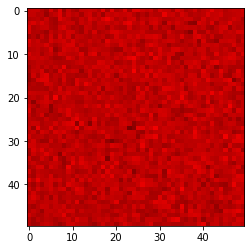

2
t:  2.083


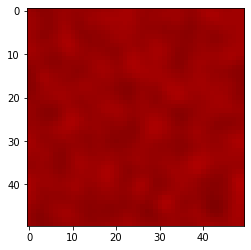

3
t:  4.166


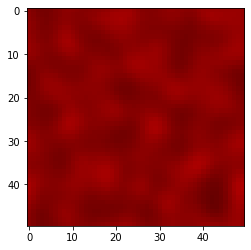

4
t:  6.2490000000000006


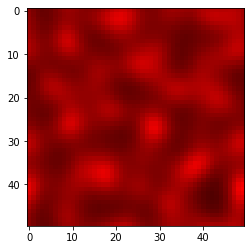

5
t:  8.332


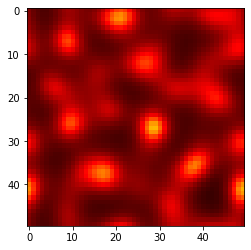

6
t:  10.415000000000001


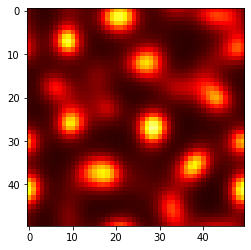

7
t:  12.498000000000001


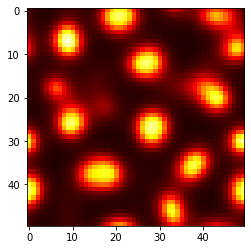

8
t:  14.581


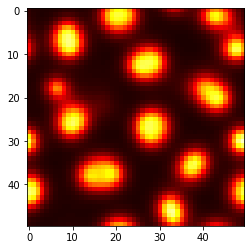

9
t:  16.664


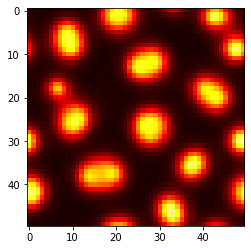

10
t:  18.747


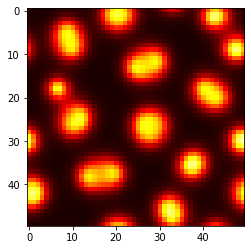

11
t:  20.830000000000002


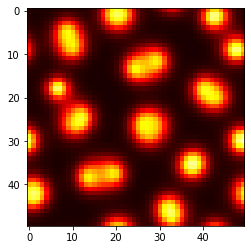

12
t:  22.913


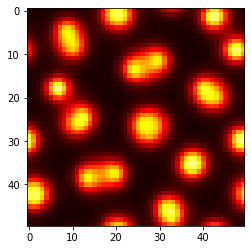

13
t:  24.996000000000002


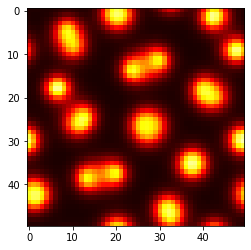

14
t:  27.079


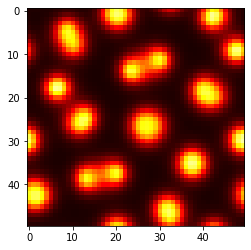

15
t:  29.162


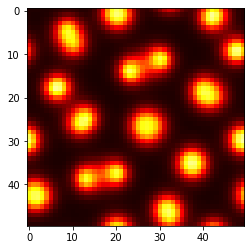

16
t:  31.245


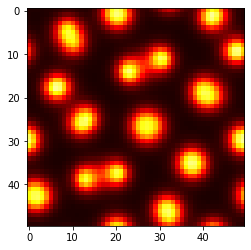

17
t:  33.328


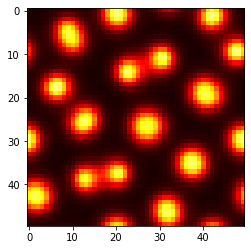

18
t:  35.411


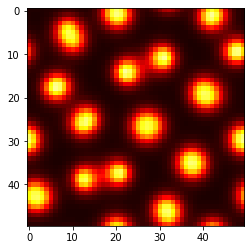

19
t:  37.494


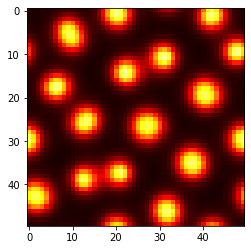

20
t:  39.577


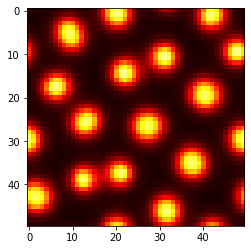

21
t:  41.660000000000004


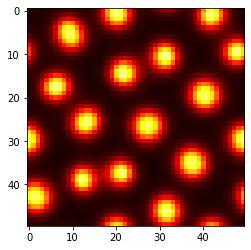

22
t:  43.743


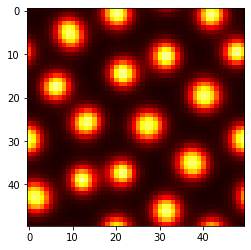

23
t:  45.826


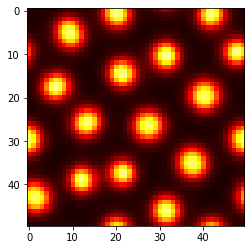

24
t:  47.909


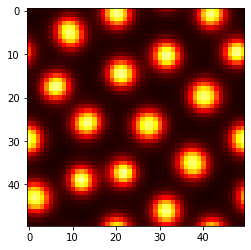

25
t:  49.992000000000004


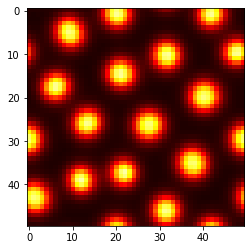

This is what the maximum of U was:  4.851543891747389


In [20]:
tSS = 0.001 #Step size of t
tNOV = int(5e4 +1) #number of values of t
tEnd = tSS*(tNOV-1) #the last t
tV = np.linspace(0,tEnd,tNOV) # a vector with all the t values
#print(tV)

SPR = 5 #Number of subplot rows
SPC = 5 #Number of subplot columns
NOSP = SPR*SPC #number of subplots
WTSP = tNOV // (NOSP-1) #When To SubPlot
#print("WTSP: ", WTSP)


#vm is the value that will show the maximum brightness in the plot. I usually pick vm to be just a bit over Umaxmax.
#For Schnakenberg
vm=5 # When mean_centre = 1 , standard_deviation = 0.1 then Umaxmax = 4.944
#For angelfishPomacanthus
#vm = 2.917
#For AlanTuring()
#vm = 3


r = 50 #Number of rows of cells
c = 50 #Number of columns of cells
mean_centre = 1 #Mean “centre” of the distribution of the initial concentration of U and V.
standard_deviation = 0.1 #Standard deviation of the of the initial concentration of U and V.
U = np.random.normal(mean_centre, standard_deviation,[r,c]) #Creating the initial values of morphogen U. With a standard distribution of scale 1 around the centre 2
V = np.random.normal(1,0.1,[r,c]) #Creating the initial values of morphogen V. With a standard distribution of scale 1 around the centre 2
#print(U)
#print("sum of V: ", np.sum(V))

#UV and VV are big arrays that are used to store U and V for all times. 
#They are not used in this code but in the the manim animation.
UV = np.zeros([tNOV,r,c]) #An array that will be filled with U for all steps of time
UV[0,:,:] = U #Putting in the initial values of U in UV
VV = np.zeros([tNOV,r,c]) #An array that will be filled with V for all steps of time
VV[0,:,:] = V #Putting in the initial values of V in VV

plt.imshow(U, cmap='hot', interpolation='nearest', vmin=0, vmax=3.7)
plt.show()

SPN = 1 #Which number of subplot you are ploting in
#fig = plt.figure()
#plt.subplot(SPR, SPC, SPN)
#plt.imshow(U, cmap='hot', interpolation='nearest')

#Umaxmax and Vmaxmax will be used to check what the maximal concentration of U and V was for all values of t
Umaxmax = U.max()
Vmaxmax = V.max()


for t in range(1,tNOV): #Moving forward in time each time this loops.
    #Choose which reaction model you want to use. Remember to change vm further up in the code as well.
    [deltaU,deltaV] = Schnakenberg(U,V)
    #[deltaU,deltaV] = GiererMeinhardt(U,V)
    #[deltaU,deltaV] = angelfishPomacanthus(U,V)
    #[deltaU,deltaV] = GrayScott(U,V)
    #[deltaU,deltaV] = AlanTuring(U,V)
    
    UNext = U + tSS*deltaU #U one time step forward in time
    VNext = V + tSS*deltaV #V one time step forward in time
    U = UNext #I do this for the next iteration in the loop 
    V = VNext #I do this for the next iteration in the loop
    UV[t,:,:] = U #Filling up UV with U for all the time steps
    VV[t,:,:] = V #Filling up VV with V for all the time steps
    
    # Checking if the we have a new concentration maximum of U and V
    if (U.max()>Umaxmax):
        Umaxmax = U.max()
        #print("nytt U.max(): ", U.max())
    if (V.max()>Vmaxmax):
        Vmaxmax = V.max()
    
    # Makes it so I dont plot/print for every time step but will instead plot/print something NOSP number of times total.
    if (t%WTSP== 0):
        SPN += 1 #To make the subplot work. Makes sure I plot the subplot at the right place in the plot.
        print(SPN)
        print("t: ",tSS*t)
        #print("U.max(): ", U.max())
        #print("U")
        #print(U)
        #print("V")
        #print(V)
        #print("sum of V: ", np.sum(V))
        plt.imshow(U, cmap='hot', interpolation='nearest', vmin=0, vmax=vm)
        plt.show()
        #plt.subplot(SPR, SPC, SPN)
        #plt.imshow(U, cmap='hot', interpolation='nearest')
print("This is what the maximum of U was: ", Umaxmax)
print("This is what the maximum of V was: ", Vmaxmax)


kladd nedanför

In [17]:
color_red = int(255*U[2,2]/Umaxmax)             
hex_color = '#%02x%02x%02x' % (363, 0, 0)
print(U[2,2])
print(Umaxmax)
print(color_red)
print(hex_color)
print(tNOV)

0.008748190019008208
21.078627152109625
0
#16b0000
11


## Animating the pattern with manim

In [22]:
%%manim -qm AnimateTuringPattern
#Manims positioning uses a 3D coordinate system. Uses numpy arrays. np.array([2,1,0]) is a position on the window.
#Manims default window is 8 Munits(manim units) tall and 14 + 2/9 = 14.22222.. Munits in width.
#The origo is at the center of the window

class AnimateTuringPattern(Scene):
    def construct(self):
        # It seems like all the variables from the other codes are global so I can use U and other variables in this function without having to import them.
        graph_sl = 7.5 #The graphs side length
        square_sl = graph_sl/r #The side length of each cell
        squares = VGroup() #Makes an empty "array" that I can put my square manim objects in.
        
        fps=10 #Frames per second.
        sped_up = 3 #How much the animation is sped up in comparison to real time.
        time_to_animate = 0 #used to say to the program what time step to animate. I want to animate at t=0.
        
        for t in range(0,tNOV): #Goes through time
            for i in range(0,r): #Goes through each row
                for j in range(0,c): # Goes through each column
                    if (t*tSS >= time_to_animate): #Makes it so I don't animate each time step. Just when its time_to_animate
                        #Goes from the value of U,V in the current cell in the current time step, to rgb color values, to hex color code.
                        color_red = int(255*UV[t,i,j]/Umaxmax) #Calculates the red value in rgb. 255 for Umaxmax
                        color_green = int(255*VV[t,i,j]/Vmaxmax) #Calculates the green value in rgb. 255 for Vmaxmax
                        color_blue = 0 #Does not use blue currently in the animation.
                        hex_color = '#%02x%02x%02x' % (color_red, color_green, color_blue) #Makes the rgb values into hex color code because manim uses hex color code.
                        
                        #When t=0 I create one square for each cell, fill it with the right color, move it to the right place in the scene, 
                        # and then I add it to the scene.
                        if (t==0): 
                            squares.add(Square(side_length = square_sl, color = hex_color, fill_opacity = 1).move_to([-graph_sl/2+square_sl*(0.5+i),graph_sl/2-square_sl*(0.5+j),0]))
                            self.add(squares[r*i+j])
                            
                        #Every other time I just change the color of the cell/square to match the current U and V concentration 
                        else:
                            squares[r*i+j].set_color(hex_color)
            # After I have gone through each cell for the current time step I make the animation wait 1/fps seconds because I want fps frames per second.
            #and I calculate the next time I want to animate, which depends on sped_up and fps.
            if (t*tSS >= time_to_animate):
                #time_text = Text("time: " + str(round(t*tSS,3))
                #time_text.move_to([graph_sl/2 +1,- graph_sl/2 +1, 0])
                #time_text.move_to([6,0,0])
                #self.add(time_text)
                self.wait(1/fps)
                time_to_animate += sped_up/fps #Calculates the next time step to animate.
        

[02/22/24 19:21:58] INFO     Animation 0 : Partial movie file written in                   ]8;id=892854;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=410287;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\134215                         
                             9004_1413622352_1930887019.mp4'                                                       

[02/22/24 19:22:02] INFO     Animation 1 : Partial movie file written in                   ]8;id=555620;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=70558;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3970533350.mp4'                                                       

[02/22/24 19:22:06] INFO     Animation 2 : Partial movie file written in                   ]8;id=379834;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=648426;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2483353151.mp4'                                                       

[02/22/24 19:22:10] INFO     Animation 3 : Partial movie file written in                   ]8;id=650453;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=896294;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3286598970.mp4'                                                       

[02/22/24 19:22:15] INFO     Animation 4 : Partial movie file written in                   ]8;id=360220;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=891626;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4046915146.mp4'                                                       

[02/22/24 19:22:18] INFO     Animation 5 : Partial movie file written in                   ]8;id=556028;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=404789;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2636792335.mp4'                                                       

[02/22/24 19:22:22] INFO     Animation 6 : Partial movie file written in                   ]8;id=597909;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=278486;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_452896294.mp4'                                                        

[02/22/24 19:22:26] INFO     Animation 7 : Partial movie file written in                   ]8;id=34754;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=294744;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1514795600.mp4'                                                       

[02/22/24 19:22:29] INFO     Animation 8 : Partial movie file written in                   ]8;id=275035;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=307820;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3718274604.mp4'                                                       

[02/22/24 19:22:33] INFO     Animation 9 : Partial movie file written in                   ]8;id=224035;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=869537;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_940601786.mp4'                                                        

[02/22/24 19:22:37] INFO     Animation 10 : Partial movie file written in                  ]8;id=918835;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=33572;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2719865076.mp4'                                                       

[02/22/24 19:22:40] INFO     Animation 11 : Partial movie file written in                  ]8;id=716426;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=13682;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3003812654.mp4'                                                       

[02/22/24 19:22:44] INFO     Animation 12 : Partial movie file written in                  ]8;id=952872;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=399229;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2298658352.mp4'                                                       

[02/22/24 19:22:48] INFO     Animation 13 : Partial movie file written in                  ]8;id=780289;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=501198;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_775077796.mp4'                                                        

[02/22/24 19:22:51] INFO     Animation 14 : Partial movie file written in                  ]8;id=782849;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=782938;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1531986337.mp4'                                                       

[02/22/24 19:22:55] INFO     Animation 15 : Partial movie file written in                  ]8;id=792703;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=792336;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_175587714.mp4'                                                        

[02/22/24 19:22:58] INFO     Animation 16 : Partial movie file written in                  ]8;id=29786;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=582902;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1556140808.mp4'                                                       

[02/22/24 19:23:02] INFO     Animation 17 : Partial movie file written in                  ]8;id=248681;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=55006;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2880749484.mp4'                                                       

[02/22/24 19:23:06] INFO     Animation 18 : Partial movie file written in                  ]8;id=228115;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=586176;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2224836838.mp4'                                                       

[02/22/24 19:23:09] INFO     Animation 19 : Partial movie file written in                  ]8;id=768826;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=91808;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_50320715.mp4'                                                         

[02/22/24 19:23:13] INFO     Animation 20 : Partial movie file written in                  ]8;id=429826;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=311552;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_144279275.mp4'                                                        

[02/22/24 19:23:16] INFO     Animation 21 : Partial movie file written in                  ]8;id=57913;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=820514;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3052641261.mp4'                                                       

[02/22/24 19:23:20] INFO     Animation 22 : Partial movie file written in                  ]8;id=429056;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=791335;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2495406238.mp4'                                                       

[02/22/24 19:23:24] INFO     Animation 23 : Partial movie file written in                  ]8;id=385265;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=614350;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3677514943.mp4'                                                       

[02/22/24 19:23:27] INFO     Animation 24 : Partial movie file written in                  ]8;id=592546;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=76154;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_389585391.mp4'                                                        

[02/22/24 19:23:31] INFO     Animation 25 : Partial movie file written in                  ]8;id=89491;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=488058;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2809388002.mp4'                                                       

[02/22/24 19:23:34] INFO     Animation 26 : Partial movie file written in                  ]8;id=640332;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=409896;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2631000447.mp4'                                                       

[02/22/24 19:23:38] INFO     Animation 27 : Partial movie file written in                  ]8;id=37301;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=518015;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1098942535.mp4'                                                       

[02/22/24 19:23:42] INFO     Animation 28 : Partial movie file written in                  ]8;id=449516;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=414029;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_622695029.mp4'                                                        

[02/22/24 19:23:45] INFO     Animation 29 : Partial movie file written in                  ]8;id=977045;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=851072;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1455284007.mp4'                                                       

[02/22/24 19:23:49] INFO     Animation 30 : Partial movie file written in                  ]8;id=720877;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=725879;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3839958119.mp4'                                                       

[02/22/24 19:23:53] INFO     Animation 31 : Partial movie file written in                  ]8;id=469767;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=498363;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3360265926.mp4'                                                       

[02/22/24 19:23:57] INFO     Animation 32 : Partial movie file written in                  ]8;id=352402;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=198415;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2850190814.mp4'                                                       

[02/22/24 19:24:01] INFO     Animation 33 : Partial movie file written in                  ]8;id=82031;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=514188;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2067188380.mp4'                                                       

[02/22/24 19:24:04] INFO     Animation 34 : Partial movie file written in                  ]8;id=8309;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=31006;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2993167564.mp4'                                                       

[02/22/24 19:24:08] INFO     Animation 35 : Partial movie file written in                  ]8;id=623271;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=316287;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3745907429.mp4'                                                       

[02/22/24 19:24:12] INFO     Animation 36 : Partial movie file written in                  ]8;id=655096;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=577165;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2628662521.mp4'                                                       

[02/22/24 19:24:15] INFO     Animation 37 : Partial movie file written in                  ]8;id=919566;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=186605;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1258900694.mp4'                                                       

[02/22/24 19:24:19] INFO     Animation 38 : Partial movie file written in                  ]8;id=791549;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=124268;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1853218027.mp4'                                                       

[02/22/24 19:24:23] INFO     Animation 39 : Partial movie file written in                  ]8;id=886824;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=525944;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3912839166.mp4'                                                       

[02/22/24 19:24:26] INFO     Animation 40 : Partial movie file written in                  ]8;id=719828;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=500382;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2908624424.mp4'                                                       

[02/22/24 19:24:30] INFO     Animation 41 : Partial movie file written in                  ]8;id=832596;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=667064;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2180344604.mp4'                                                       

[02/22/24 19:24:34] INFO     Animation 42 : Partial movie file written in                  ]8;id=675301;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=459051;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3703829635.mp4'                                                       

[02/22/24 19:24:37] INFO     Animation 43 : Partial movie file written in                  ]8;id=864016;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=667416;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3411392245.mp4'                                                       

[02/22/24 19:24:41] INFO     Animation 44 : Partial movie file written in                  ]8;id=53667;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=820193;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2079695590.mp4'                                                       

[02/22/24 19:24:45] INFO     Animation 45 : Partial movie file written in                  ]8;id=69628;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=522534;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3824038449.mp4'                                                       

[02/22/24 19:24:49] INFO     Animation 46 : Partial movie file written in                  ]8;id=772095;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=434718;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2431386012.mp4'                                                       

[02/22/24 19:24:52] INFO     Animation 47 : Partial movie file written in                  ]8;id=146030;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=289898;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_854824462.mp4'                                                        

[02/22/24 19:24:56] INFO     Animation 48 : Partial movie file written in                  ]8;id=392295;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=952195;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_74159586.mp4'                                                         

[02/22/24 19:24:59] INFO     Animation 49 : Partial movie file written in                  ]8;id=943859;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=481188;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_87120914.mp4'                                                         

[02/22/24 19:25:03] INFO     Animation 50 : Partial movie file written in                  ]8;id=851541;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=877628;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1663601134.mp4'                                                       

[02/22/24 19:25:07] INFO     Animation 51 : Partial movie file written in                  ]8;id=687432;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=402238;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3513235292.mp4'                                                       

[02/22/24 19:25:10] INFO     Animation 52 : Partial movie file written in                  ]8;id=605621;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=419691;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1459576558.mp4'                                                       

[02/22/24 19:25:14] INFO     Animation 53 : Partial movie file written in                  ]8;id=969124;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=394144;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3872170333.mp4'                                                       

[02/22/24 19:25:18] INFO     Animation 54 : Partial movie file written in                  ]8;id=117134;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=911809;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3873542745.mp4'                                                       

[02/22/24 19:25:21] INFO     Animation 55 : Partial movie file written in                  ]8;id=323719;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=903842;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_121791301.mp4'                                                        

[02/22/24 19:25:25] INFO     Animation 56 : Partial movie file written in                  ]8;id=670703;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=13031;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1055509103.mp4'                                                       

[02/22/24 19:25:29] INFO     Animation 57 : Partial movie file written in                  ]8;id=693047;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=777179;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4165968679.mp4'                                                       

[02/22/24 19:25:33] INFO     Animation 58 : Partial movie file written in                  ]8;id=338176;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=416045;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2433859427.mp4'                                                       

[02/22/24 19:25:36] INFO     Animation 59 : Partial movie file written in                  ]8;id=897093;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=620998;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_977063478.mp4'                                                        

[02/22/24 19:25:40] INFO     Animation 60 : Partial movie file written in                  ]8;id=258606;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=512771;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3585677209.mp4'                                                       

[02/22/24 19:25:44] INFO     Animation 61 : Partial movie file written in                  ]8;id=986979;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=433383;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_348738441.mp4'                                                        

[02/22/24 19:25:48] INFO     Animation 62 : Partial movie file written in                  ]8;id=256076;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=639245;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_747364325.mp4'                                                        

[02/22/24 19:25:51] INFO     Animation 63 : Partial movie file written in                  ]8;id=251044;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=792057;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_520295703.mp4'                                                        

[02/22/24 19:25:55] INFO     Animation 64 : Partial movie file written in                  ]8;id=940155;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=583290;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1672677675.mp4'                                                       

[02/22/24 19:25:59] INFO     Animation 65 : Partial movie file written in                  ]8;id=510046;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=391019;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2791140506.mp4'                                                       

[02/22/24 19:26:02] INFO     Animation 66 : Partial movie file written in                  ]8;id=509480;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=595945;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1898657981.mp4'                                                       

[02/22/24 19:26:06] INFO     Animation 67 : Partial movie file written in                  ]8;id=942643;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=815878;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3536517300.mp4'                                                       

[02/22/24 19:26:09] INFO     Animation 68 : Partial movie file written in                  ]8;id=150616;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=184225;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3104823056.mp4'                                                       

[02/22/24 19:26:13] INFO     Animation 69 : Partial movie file written in                  ]8;id=109081;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=318526;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3158267875.mp4'                                                       

[02/22/24 19:26:17] INFO     Animation 70 : Partial movie file written in                  ]8;id=298919;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=964852;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2787330274.mp4'                                                       

[02/22/24 19:26:20] INFO     Animation 71 : Partial movie file written in                  ]8;id=846991;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=438698;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1811451848.mp4'                                                       

[02/22/24 19:26:24] INFO     Animation 72 : Partial movie file written in                  ]8;id=832522;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=90670;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1544400212.mp4'                                                       

[02/22/24 19:26:27] INFO     Animation 73 : Partial movie file written in                  ]8;id=241252;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=351819;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2466137694.mp4'                                                       

[02/22/24 19:26:31] INFO     Animation 74 : Partial movie file written in                  ]8;id=848611;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=874430;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2087959389.mp4'                                                       

[02/22/24 19:26:35] INFO     Animation 75 : Partial movie file written in                  ]8;id=332240;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=492855;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3451014858.mp4'                                                       

[02/22/24 19:26:38] INFO     Animation 76 : Partial movie file written in                  ]8;id=921162;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=774291;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3084485449.mp4'                                                       

[02/22/24 19:26:42] INFO     Animation 77 : Partial movie file written in                  ]8;id=132343;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=384225;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1057985307.mp4'                                                       

[02/22/24 19:26:46] INFO     Animation 78 : Partial movie file written in                  ]8;id=959442;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=101601;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2564603280.mp4'                                                       

[02/22/24 19:26:49] INFO     Animation 79 : Partial movie file written in                  ]8;id=867880;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=861290;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1721097916.mp4'                                                       

[02/22/24 19:26:53] INFO     Animation 80 : Partial movie file written in                  ]8;id=55305;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=379909;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3091656334.mp4'                                                       

[02/22/24 19:26:56] INFO     Animation 81 : Partial movie file written in                  ]8;id=32218;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=806538;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2733870215.mp4'                                                       

[02/22/24 19:27:00] INFO     Animation 82 : Partial movie file written in                  ]8;id=589127;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=838910;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3780201886.mp4'                                                       

[02/22/24 19:27:04] INFO     Animation 83 : Partial movie file written in                  ]8;id=824684;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=28348;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_172967845.mp4'                                                        

[02/22/24 19:27:07] INFO     Animation 84 : Partial movie file written in                  ]8;id=408090;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=409508;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4076712336.mp4'                                                       

[02/22/24 19:27:11] INFO     Animation 85 : Partial movie file written in                  ]8;id=504838;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=869239;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4121362876.mp4'                                                       

[02/22/24 19:27:14] INFO     Animation 86 : Partial movie file written in                  ]8;id=107450;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=284799;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4184969159.mp4'                                                       

[02/22/24 19:27:18] INFO     Animation 87 : Partial movie file written in                  ]8;id=713109;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=772437;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3261672825.mp4'                                                       

[02/22/24 19:27:22] INFO     Animation 88 : Partial movie file written in                  ]8;id=767790;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=118239;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_263286752.mp4'                                                        

[02/22/24 19:27:26] INFO     Animation 89 : Partial movie file written in                  ]8;id=550166;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=543866;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_788547728.mp4'                                                        

[02/22/24 19:27:29] INFO     Animation 90 : Partial movie file written in                  ]8;id=776029;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=690647;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1547356007.mp4'                                                       

[02/22/24 19:27:33] INFO     Animation 91 : Partial movie file written in                  ]8;id=319825;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=155081;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1098074435.mp4'                                                       

[02/22/24 19:27:36] INFO     Animation 92 : Partial movie file written in                  ]8;id=527453;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=657128;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_916175733.mp4'                                                        

[02/22/24 19:27:41] INFO     Animation 93 : Partial movie file written in                  ]8;id=196825;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=547615;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_145908225.mp4'                                                        

[02/22/24 19:27:46] INFO     Animation 94 : Partial movie file written in                  ]8;id=198959;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=440779;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_734233281.mp4'                                                        

[02/22/24 19:27:50] INFO     Animation 95 : Partial movie file written in                  ]8;id=219936;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=575208;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_521996082.mp4'                                                        

[02/22/24 19:27:54] INFO     Animation 96 : Partial movie file written in                  ]8;id=947568;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=523684;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3323426930.mp4'                                                       

[02/22/24 19:27:57] INFO     Animation 97 : Partial movie file written in                  ]8;id=414237;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=939943;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3693451103.mp4'                                                       

[02/22/24 19:28:01] INFO     Animation 98 : Partial movie file written in                  ]8;id=988024;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=652106;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1101568649.mp4'                                                       

[02/22/24 19:28:05] INFO     Animation 99 : Partial movie file written in                  ]8;id=809769;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=803075;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_669303968.mp4'                                                        

[02/22/24 19:28:08] INFO     Animation 100 : Partial movie file written in                 ]8;id=493148;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=700357;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_505060271.mp4'                                                        

[02/22/24 19:28:12] INFO     Animation 101 : Partial movie file written in                 ]8;id=553684;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=261251;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4079397734.mp4'                                                       

[02/22/24 19:28:16] INFO     Animation 102 : Partial movie file written in                 ]8;id=157796;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=323512;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3057348514.mp4'                                                       

[02/22/24 19:28:20] INFO     Animation 103 : Partial movie file written in                 ]8;id=726256;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=747952;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1667018489.mp4'                                                       

[02/22/24 19:28:23] INFO     Animation 104 : Partial movie file written in                 ]8;id=949104;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=802460;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1491282929.mp4'                                                       

[02/22/24 19:28:27] INFO     Animation 105 : Partial movie file written in                 ]8;id=576237;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=988875;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2572656884.mp4'                                                       

[02/22/24 19:28:30] INFO     Animation 106 : Partial movie file written in                 ]8;id=296917;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=38750;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3533710801.mp4'                                                       

[02/22/24 19:28:34] INFO     Animation 107 : Partial movie file written in                 ]8;id=264925;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=269624;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1408739963.mp4'                                                       

[02/22/24 19:28:38] INFO     Animation 108 : Partial movie file written in                 ]8;id=753135;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=509407;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2757614279.mp4'                                                       

[02/22/24 19:28:41] INFO     Animation 109 : Partial movie file written in                 ]8;id=900420;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=902535;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_723830138.mp4'                                                        

[02/22/24 19:28:45] INFO     Animation 110 : Partial movie file written in                 ]8;id=275282;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=686249;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1580991367.mp4'                                                       

[02/22/24 19:28:48] INFO     Animation 111 : Partial movie file written in                 ]8;id=57010;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=41509;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_351581955.mp4'                                                        

[02/22/24 19:28:52] INFO     Animation 112 : Partial movie file written in                 ]8;id=30415;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=855126;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1933588594.mp4'                                                       

[02/22/24 19:28:56] INFO     Animation 113 : Partial movie file written in                 ]8;id=315746;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=654624;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_185675924.mp4'                                                        

[02/22/24 19:29:00] INFO     Animation 114 : Partial movie file written in                 ]8;id=860832;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=346567;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3589173113.mp4'                                                       

[02/22/24 19:29:03] INFO     Animation 115 : Partial movie file written in                 ]8;id=801335;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=114512;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_388750296.mp4'                                                        

[02/22/24 19:29:07] INFO     Animation 116 : Partial movie file written in                 ]8;id=366174;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=594706;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4081858274.mp4'                                                       

[02/22/24 19:29:11] INFO     Animation 117 : Partial movie file written in                 ]8;id=571710;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=821572;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2741790502.mp4'                                                       

[02/22/24 19:29:14] INFO     Animation 118 : Partial movie file written in                 ]8;id=603624;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=617068;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1809494824.mp4'                                                       

[02/22/24 19:29:18] INFO     Animation 119 : Partial movie file written in                 ]8;id=439621;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=739442;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1090258142.mp4'                                                       

[02/22/24 19:29:22] INFO     Animation 120 : Partial movie file written in                 ]8;id=3471;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=243821;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_343405607.mp4'                                                        

[02/22/24 19:29:26] INFO     Animation 121 : Partial movie file written in                 ]8;id=836902;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=831985;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3627722944.mp4'                                                       

[02/22/24 19:29:29] INFO     Animation 122 : Partial movie file written in                 ]8;id=850058;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=144528;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_600340330.mp4'                                                        

[02/22/24 19:29:33] INFO     Animation 123 : Partial movie file written in                 ]8;id=832791;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=331185;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1521330393.mp4'                                                       

[02/22/24 19:29:37] INFO     Animation 124 : Partial movie file written in                 ]8;id=987764;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=146239;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1770045411.mp4'                                                       

[02/22/24 19:29:41] INFO     Animation 125 : Partial movie file written in                 ]8;id=710796;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=366580;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_407325785.mp4'                                                        

[02/22/24 19:29:44] INFO     Animation 126 : Partial movie file written in                 ]8;id=463568;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=561826;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3542156623.mp4'                                                       

[02/22/24 19:29:48] INFO     Animation 127 : Partial movie file written in                 ]8;id=323470;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=874034;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_758215512.mp4'                                                        

[02/22/24 19:29:51] INFO     Animation 128 : Partial movie file written in                 ]8;id=903152;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=916906;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2468316388.mp4'                                                       

[02/22/24 19:29:55] INFO     Animation 129 : Partial movie file written in                 ]8;id=535268;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=214844;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_902455371.mp4'                                                        

[02/22/24 19:29:59] INFO     Animation 130 : Partial movie file written in                 ]8;id=877316;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=883081;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2969593324.mp4'                                                       

[02/22/24 19:30:02] INFO     Animation 131 : Partial movie file written in                 ]8;id=851136;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=69848;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1992607678.mp4'                                                       

[02/22/24 19:30:06] INFO     Animation 132 : Partial movie file written in                 ]8;id=719149;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=313286;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2191168093.mp4'                                                       

[02/22/24 19:30:09] INFO     Animation 133 : Partial movie file written in                 ]8;id=251901;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=206807;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1340797091.mp4'                                                       

[02/22/24 19:30:13] INFO     Animation 134 : Partial movie file written in                 ]8;id=722423;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=284771;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_333212284.mp4'                                                        

[02/22/24 19:30:17] INFO     Animation 135 : Partial movie file written in                 ]8;id=800461;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=678778;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2288531973.mp4'                                                       

[02/22/24 19:30:20] INFO     Animation 136 : Partial movie file written in                 ]8;id=185984;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=514230;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2269360484.mp4'                                                       

[02/22/24 19:30:24] INFO     Animation 137 : Partial movie file written in                 ]8;id=426385;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=168591;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2453602167.mp4'                                                       

[02/22/24 19:30:27] INFO     Animation 138 : Partial movie file written in                 ]8;id=580347;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=188148;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4122403377.mp4'                                                       

[02/22/24 19:30:31] INFO     Animation 139 : Partial movie file written in                 ]8;id=32834;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=154801;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_813213962.mp4'                                                        

[02/22/24 19:30:35] INFO     Animation 140 : Partial movie file written in                 ]8;id=604843;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=30663;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1528156802.mp4'                                                       

[02/22/24 19:30:38] INFO     Animation 141 : Partial movie file written in                 ]8;id=361973;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=966500;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1927848219.mp4'                                                       

[02/22/24 19:30:42] INFO     Animation 142 : Partial movie file written in                 ]8;id=851091;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=480376;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2747349439.mp4'                                                       

[02/22/24 19:30:46] INFO     Animation 143 : Partial movie file written in                 ]8;id=310626;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=526467;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_140163054.mp4'                                                        

[02/22/24 19:30:49] INFO     Animation 144 : Partial movie file written in                 ]8;id=193992;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=162219;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3184895090.mp4'                                                       

[02/22/24 19:30:53] INFO     Animation 145 : Partial movie file written in                 ]8;id=465732;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=970882;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_110235797.mp4'                                                        

[02/22/24 19:30:57] INFO     Animation 146 : Partial movie file written in                 ]8;id=99715;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=847985;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1214700428.mp4'                                                       

[02/22/24 19:31:01] INFO     Animation 147 : Partial movie file written in                 ]8;id=500542;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=213157;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_58878421.mp4'                                                         

[02/22/24 19:31:05] INFO     Animation 148 : Partial movie file written in                 ]8;id=827742;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=510032;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2921031726.mp4'                                                       

[02/22/24 19:31:09] INFO     Animation 149 : Partial movie file written in                 ]8;id=430693;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=335758;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3327967418.mp4'                                                       

[02/22/24 19:31:12] INFO     Animation 150 : Partial movie file written in                 ]8;id=273897;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=344082;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3117138865.mp4'                                                       

[02/22/24 19:31:16] INFO     Animation 151 : Partial movie file written in                 ]8;id=612618;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=511571;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3454430418.mp4'                                                       

[02/22/24 19:31:20] INFO     Animation 152 : Partial movie file written in                 ]8;id=976648;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=919947;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2229415267.mp4'                                                       

[02/22/24 19:31:24] INFO     Animation 153 : Partial movie file written in                 ]8;id=848667;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=901261;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4050575683.mp4'                                                       

[02/22/24 19:31:27] INFO     Animation 154 : Partial movie file written in                 ]8;id=385489;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=573535;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_414505022.mp4'                                                        

[02/22/24 19:31:31] INFO     Animation 155 : Partial movie file written in                 ]8;id=877464;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=945085;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2647502990.mp4'                                                       

[02/22/24 19:31:34] INFO     Animation 156 : Partial movie file written in                 ]8;id=730815;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=784354;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3529969964.mp4'                                                       

[02/22/24 19:31:38] INFO     Animation 157 : Partial movie file written in                 ]8;id=649375;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=938904;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_221656851.mp4'                                                        

[02/22/24 19:31:42] INFO     Animation 158 : Partial movie file written in                 ]8;id=534465;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=758503;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3842669300.mp4'                                                       

[02/22/24 19:31:46] INFO     Animation 159 : Partial movie file written in                 ]8;id=566109;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=681035;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_1588863269.mp4'                                                       

[02/22/24 19:31:50] INFO     Animation 160 : Partial movie file written in                 ]8;id=167358;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=122239;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2286800965.mp4'                                                       

[02/22/24 19:31:53] INFO     Animation 161 : Partial movie file written in                 ]8;id=906673;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=13160;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_467903778.mp4'                                                        

[02/22/24 19:31:57] INFO     Animation 162 : Partial movie file written in                 ]8;id=7170;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=179522;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_4063457287.mp4'                                                       

[02/22/24 19:32:00] INFO     Animation 163 : Partial movie file written in                 ]8;id=616139;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=831160;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_3575733022.mp4'                                                       

[02/22/24 19:32:04] INFO     Animation 164 : Partial movie file written in                 ]8;id=334452;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=155742;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2847883672.mp4'                                                       

[02/22/24 19:32:08] INFO     Animation 165 : Partial movie file written in                 ]8;id=324243;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=959835;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_882605616.mp4'                                                        

[02/22/24 19:32:14] INFO     Animation 166 : Partial movie file written in                 ]8;id=833004;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=209332;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\AnimateTuringPattern\135361                         
                             8911_2686367673_2447215151.mp4'                                                       

[02/22/24 19:32:15] INFO     Combining to Movie file.                                      ]8;id=216194;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=412430;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#607\607]8;;\

[02/22/24 19:32:16] INFO                                                                   ]8;id=806019;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=653439;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#728\728]8;;\
                             File ready at 'C:\Users\Admin\Documents\Jupyter notes                                 
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\AnimateTuringPattern.mp4'                                               
                                                                                                                   

[02/22/24 19:32:17] INFO     The partial movie directory is full (> 200 files). Therefore, ]8;id=477025;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=891116;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#699\699]8;;\
                             manim has removed the 167 oldest file(s). You can change this                         
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered AnimateTuringPattern                                             ]8;id=680935;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=524238;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py#240\240]8;;\
                             Played 167 animations                                                                 

Used to just show an image of a certain time step. Haven't updated it in a while though...

[02/20/24 21:06:21] INFO                                                                   ]8;id=108972;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=11811;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#728\728]8;;\
                             File ready at 'C:\Users\Admin\Documents\Jupyter notes                                 
                             folder\media\images\Jupyter notes                                                     
                             folder\Test1time_ManimCE_v0.16.0.post0.png'                                           
                                                                                                                   

                    INFO     Rendered Test1time                                                        ]8;id=11110;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=891579;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py#240\240]8;;\
                             Played 0 animations                                                                   

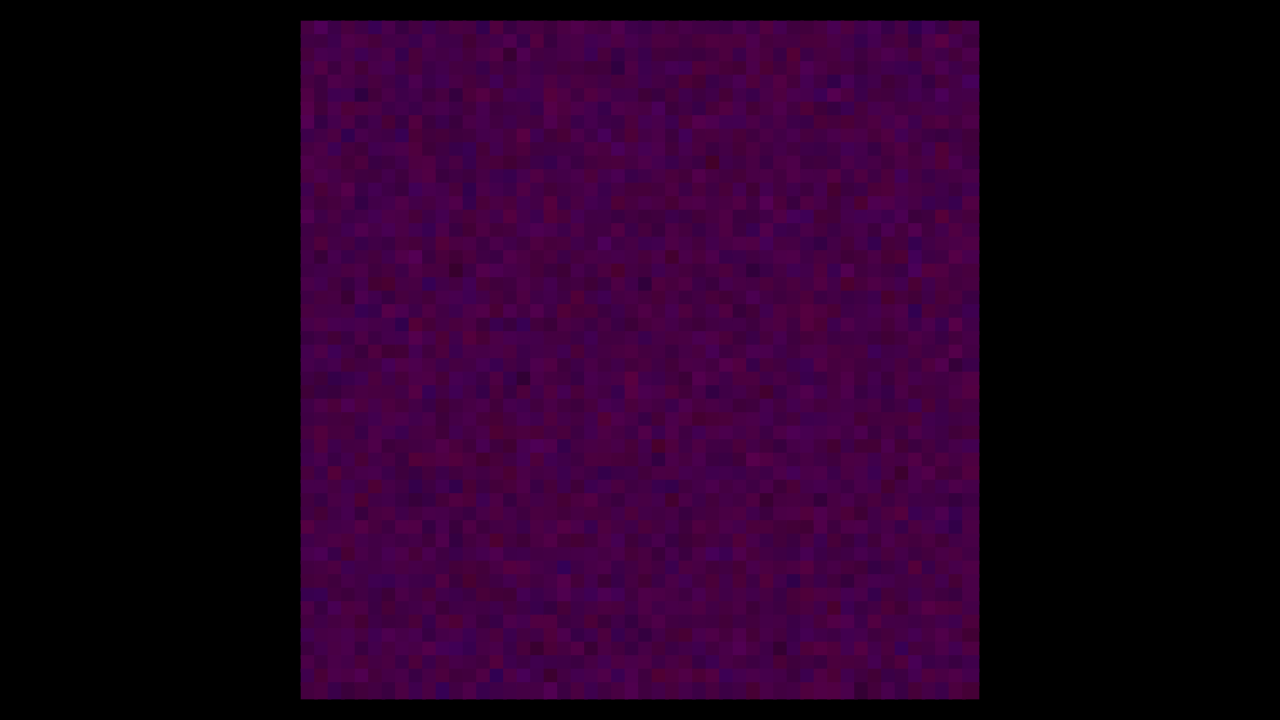

In [40]:
%%manim -qm Test1time
## Playing U and V for one point in time
class Test1time(Scene):
    def construct(self):
        graph_sl = 7.5 #The graphs side length
        square_sl = graph_sl/r
        point_in_time = 10
        
        squares = VGroup()
        for t in range(0,tNOV):
            for i in range(0,r):
                for j in range(0,c):
                    color_red = int(255*UV[0,i,j]/Umaxmax)
                    color_blue = int(255*VV[0,i,j]/Vmaxmax)
                    hex_color = '#%02x%02x%02x' % (color_red, 0, color_blue)
                    if (t==point_in_time):
                        squares.add(Square(side_length = square_sl, color = hex_color, fill_opacity = 1).move_to([-graph_sl/2+square_sl*(0.5+i),graph_sl/2-square_sl*(0.5+j),0]))
                        self.add(squares[r*i+j])


Everything below this is "kladd" or things that I have given up on.

[02/20/24 22:14:53] INFO                                                                   ]8;id=128904;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=831543;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#728\728]8;;\
                             File ready at 'C:\Users\Admin\Documents\Jupyter notes                                 
                             folder\media\images\Jupyter notes                                                     
                             folder\TestTimeText_ManimCE_v0.16.0.post0.png'                                        
                                                                                                                   

                    INFO     Rendered TestTimeText                                                     ]8;id=202328;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=553950;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py#240\240]8;;\
                             Played 0 animations                                                                   

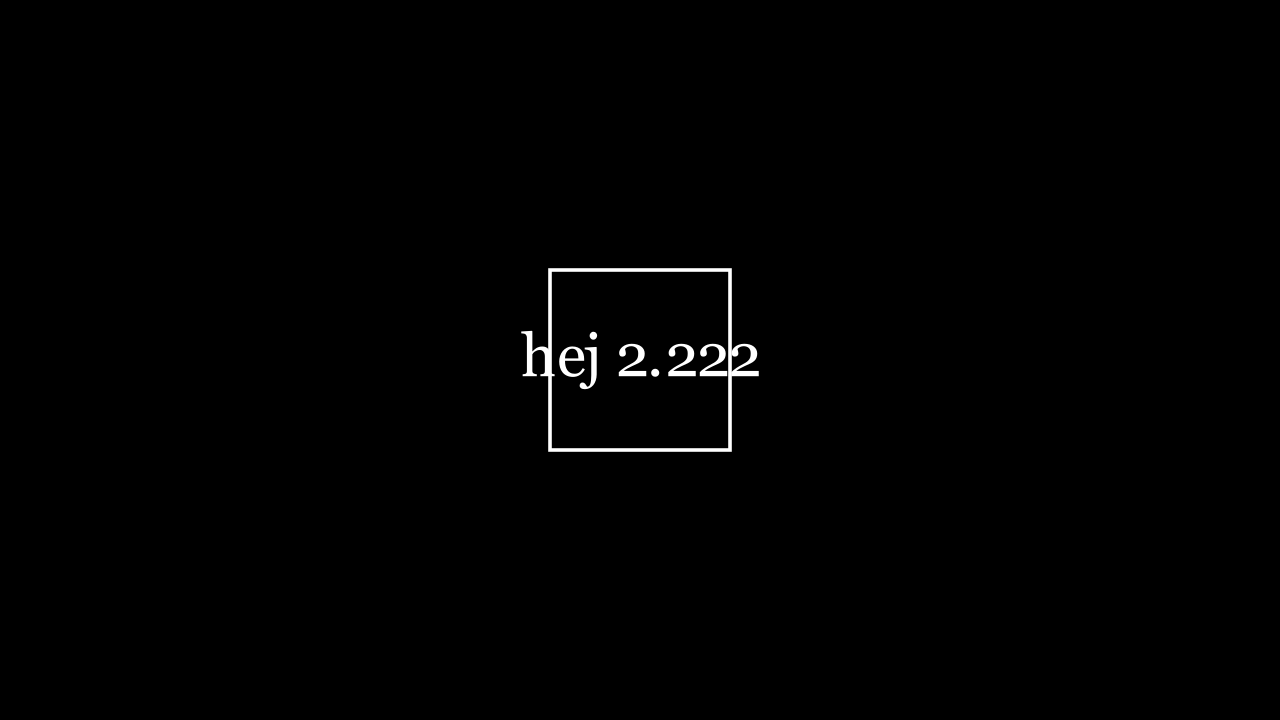

In [69]:
%%manim -qm TestTimeText

class TestTimeText(Scene):
    def construct(self):
        time_str = "hej " + str(round(2.2222,3))
        time_text = Text("hej " + str(round(2.2222,3)))
        #time_text.move_to([3,2,0])
        fyrkant = Square()
        self.add(time_text,fyrkant)

In [58]:
x = 0.11111
time_str = "hej " + str(round(x,3))
print(time_str)

hej 0.111


In [77]:
print(r)
for j in range(0,c):
    for i in range(0,r):
        print(7.5/2+0.5+i,7.5/2-0.5-j)


3
4.25 3.25
5.25 3.25
6.25 3.25
4.25 2.25
5.25 2.25
6.25 2.25
4.25 1.25
5.25 1.25
6.25 1.25


In [96]:
UVector = np.zeros([5,r,c])
UVector[0,:,:] = U
print(UVector)

[[[1.09249088 1.09592619 1.10648586]
  [1.08318281 1.08771387 1.09789125]
  [1.09060725 1.0932074  1.1047419 ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]]


OSError: [WinError 193] %1 är inte ett giltigt Win32-program

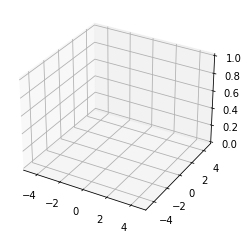

In [8]:
import numpy as np
import matplotlib
# matplotlib.use("Agg") # useful for a webserver case where you don't want to ever visualize the result live.
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter, PillowWriter

# Change to reflect your file location!
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\Admin\\anaconda3\\lib\\site-packages\\pyglet\\media\\codecs\\ffmpeg.py'


# Fixing random state for reproducibility
np.random.seed(19680801)


metadata = dict(title='Movie', artist='codinglikemad')
# writer = PillowWriter(fps=15, metadata=metadata)
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

plt.xlim(-5, 5)
plt.ylim(-5, 5)


def func(x,y,r,t):
    return np.cos(r/2+t)*np.exp(-np.square(r)/50)

xvec = np.linspace(-10, 10, 1000)
yvec = np.linspace(-10, 10, 1000)

xlist, ylist = np.meshgrid(xvec, yvec)

rlist = np.sqrt( np.square(xlist) + np.square(ylist) )

with writer.saving(fig, "exp3d.mp4", 100):
    for tval in np.linspace(0,20,160):
        print(tval)
        zval = func(xlist,ylist,rlist, tval)
        ax.set_zlim(-1, 1)
        ax.plot_surface(xlist,ylist,zval,cmap=cm.viridis)

        writer.grab_frame()
        plt.cla()

OSError: [WinError 193] %1 är inte ett giltigt Win32-program

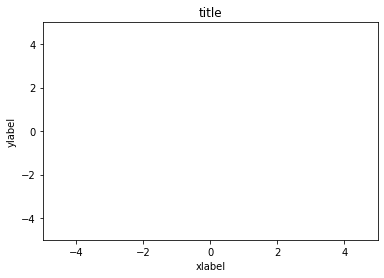

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# This needs to be changed for your code
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\Admin\\anaconda3\\lib\\site-packages\\pyglet\\media\\codecs\\ffmpeg.py'

# This is the final example I showed in the code - notice I have 2 "cursor marks" not shown in the video
fig = plt.figure()
l, = plt.plot([], [], 'k-')
l2, = plt.plot([], [], 'm--')
p1, = plt.plot([], [], 'ko')
p2, = plt.plot([], [], 'mo')

plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('title')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

def func(x):
    return np.sin(x)*3

def func2(x):
    return np.cos(x)*3

metadata = dict(title='Movie', artist='codinglikemad')
writer = FFMpegWriter(fps=15, metadata=metadata)


xlist = []
xlist2 = []
ylist = []
ylist2 = []

with writer.saving(fig, "sinWave2.mp4", 100):

    # Plot the first line and cursor
    for xval in np.linspace(-5,5,100):
        xlist.append(xval)
        ylist.append(func(xval))

        l.set_data(xlist,ylist)
        l2.set_data(xlist2,ylist2)

        p1.set_data(xval,func(xval))

        writer.grab_frame()

    # plot the second line and cursor
    for xval in np.linspace(-5,5,100):
        xlist2.append(xval)
        ylist2.append(func2(xval))

        l.set_data(xlist,ylist)
        l2.set_data(xlist2,ylist2)

        p2.set_data(xval,func2(xval))

        writer.grab_frame()

In [17]:
%%manim -qm FirstTry

'''Skapar en video som visar att x^2 - 1 = (x-1)(x+1)'''
class FirstTry(Scene):
    def construct(self):
        #Skapar den stora gröna kvadraten och ritar den.
        bigSquare = Square(side_length = 3, color = GREEN, fill_opacity = 0.5)
        bigSquare.move_to([-0.5,-0.5,0])
        self.add(bigSquare)

        #Skapar rutnätet och ritar det.
        plane = NumberPlane()
        self.add(plane)

        #Skapar den lilla röda kvadraten och ritar den.
        littleSquare = Square(side_length = 1, color = RED, fill_opacity = 0.5)
        self.add(littleSquare)
        littleSquare.move_to([1.5,1.5,0])
        
        #Skapar de två blåa rektanglarna, flyttar dem och ritar dem.
        upRectangle = Rectangle(height = 1, width = 3, color = BLUE, fill_opacity = 0.5)
        upRectangle.move_to([-0.5,1.5,0])
        rightRectangle = Rectangle(height = 3, width = 1, color = BLUE, fill_opacity = 0.5)
        rightRectangle.move_to([1.5,-0.5,0])
        self.add(upRectangle,rightRectangle)

        #För att rita ut x och mätlinjerna
        b1 = BraceBetweenPoints([2,2,0],[-2,2,0])
        b1Tex = b1.get_tex('x')
        b2 = BraceBetweenPoints([2,-2,0],[2,2,0])
        b2Tex = b2.get_tex('x')

        #Skapar ekvationen. 
        ekvation=MathTex("x^2","-1", "=","(x-1)(x+1)")
        ekvation.move_to(3*UP+LEFT)

        #Skriver ut början av ekvationen och visar att kvadratens längd = x.
        self.play(FadeIn(b1,b1Tex,b2,b2Tex))
        self.play(Write(ekvation[0]))
        self.wait()

        
        #Skapar texten -1
        littleSquareTex = Tex('-1')
        littleSquareTex.next_to(littleSquare, RIGHT)

        #Skriver ut -1 och tar bort mätningarna av kvadratens längd
        self.play(FadeIn(littleSquareTex),FadeOut(b1,b1Tex,b2,b2Tex))
        #tar bort den lilla kvadraten och dens text
        self.play(FadeOut(littleSquare),FadeOut(littleSquareTex))
        #Skriver ut -1 i ekvationen över.
        self.play(Write(ekvation[1]))
        self.wait()

        #Roterar och flyttar den översta rektangeln. Skriver också ut "=" i ekvationen
#         self.play(upRectangle.animate.rotate(0.5*pi).move_to([-2.5,-0.5,0]),Write(ekvation[2]))
        

        #För att rita x-1, x+1 och mätlinjen
        b3 = BraceBetweenPoints([-3,1,0],[-3,-2,0])
        b3Tex = b3.get_tex('x-1')
        b4 = BraceBetweenPoints([-3,-2,0],[2,-2,0])
        b4Tex = b4.get_tex('x+1')
        self.play(FadeIn(b3,b3Tex,b4,b4Tex))
        
        #Skriver ut högerledet på ekvationen
        self.play(Write(ekvation[3]))
        self.wait(2)


[02/22/24 19:03:56] INFO     Animation 0 : Using cached data (hash :                           ]8;id=439621;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=498599;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1342159004_3056798251_2936676431)                                                     

[02/22/24 19:03:57] INFO     Animation 1 : Using cached data (hash :                           ]8;id=133600;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=568418;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1353618911_1835404313_972447806)                                                      

                    INFO     Animation 2 : Using cached data (hash :                           ]8;id=955064;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=64113;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1353618911_3315967912_541851504)                                                      

                    INFO     Animation 3 : Using cached data (hash :                           ]8;id=713692;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=13696;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1353618911_2809083146_4127755475)                                                     

                    INFO     Animation 4 : Using cached data (hash :                           ]8;id=673043;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=171918;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1353618911_495643997_362673509)                                                       

                    INFO     Animation 5 : Using cached data (hash :                           ]8;id=220054;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=318889;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1353618911_1453815204_4109140635)                                                     

[02/22/24 19:03:58] INFO     Animation 6 : Using cached data (hash :                           ]8;id=371209;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=118443;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\renderer\cairo_renderer.py#75\75]8;;\
                             1353618911_3315967912_2786337192)                                                     

[02/22/24 19:04:01] INFO     Animation 7 : Partial movie file written in                   ]8;id=243915;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=136340;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\FirstTry\1353618911_1862656                         
                             536_3750994614.mp4'                                                                   

[02/22/24 19:04:03] INFO     Animation 8 : Partial movie file written in                   ]8;id=42534;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=347701;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\FirstTry\1353618911_2893477                         
                             211_2579631854.mp4'                                                                   

[02/22/24 19:04:04] INFO     Animation 9 : Partial movie file written in                   ]8;id=117819;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=207772;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#514\514]8;;\
                             'C:\Users\Admin\Documents\Jupyter notes                                               
                             folder\media\videos\Jupyter notes                                                     
                             folder\720p30\partial_movie_files\FirstTry\1353618911_1908007                         
                             90_1567827880.mp4'                                                                    

                    INFO     Combining to Movie file.                                      ]8;id=305912;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=101804;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#607\607]8;;\

                    INFO                                                                   ]8;id=716866;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=165455;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene_file_writer.py#728\728]8;;\
                             File ready at 'C:\Users\Admin\Documents\Jupyter notes                                 
                             folder\media\videos\Jupyter notes folder\720p30\FirstTry.mp4'                         
                                                                                                                   

                    INFO     Rendered FirstTry                                                         ]8;id=87739;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=856370;file://C:\Users\Admin\anaconda3\lib\site-packages\manim\scene\scene.py#240\240]8;;\
                             Played 10 animations                                                                  

Empty equation-model

$$
\left. \begin{aligned}
&   \\
&
\end{aligned} \right\}
$$